In [16]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime as dt
from datetime import datetime
%matplotlib inline

from matplotlib import pyplot as plt
from sklearn import model_selection
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from dotenv import load_dotenv
load_dotenv()
from pathlib import Path

from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import InputLayer

from numpy import array
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

In [2]:
dataset_train = pd.read_csv('/Users/bcas/Downloads/CSX.csv')

cols = list(dataset_train)[1:6]

datelist_train = list(dataset_train['Date'])
datelist_train = [dt.datetime.strptime(date, '%Y-%m-%d').date() for date in datelist_train]

print('Training set shape == {}'.format(dataset_train.shape))
print('All timestamps == {}'.format(len(datelist_train)))
print('Featured selected: {}'.format(cols))

Training set shape == (10068, 7)
All timestamps == 10068
Featured selected: ['Open', 'High', 'Low', 'Close', 'Adj Close']


In [3]:
dataset_train = dataset_train[cols].astype(str)

for i in cols:
    for j in range(0, len(dataset_train)):
        dataset_train[i][j] = dataset_train[i][j].replace(',', '')
        
dataset_train = dataset_train.astype(float)

# Using multiple predictors (features)

training_set = dataset_train.as_matrix()

print('Shape of training set == {}.'.format(training_set.shape))
training_set

Shape of training set == (10068, 5).


/Users/bcas/anaconda3/envs/algotrading/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  # This is added back by InteractiveShellApp.init_path()


array([[ 1.163194,  1.211806,  1.163194,  1.194444,  0.360112],
       [ 1.201389,  1.25    ,  1.201389,  1.236111,  0.372674],
       [ 1.243056,  1.267361,  1.243056,  1.267361,  0.382096],
       ...,
       [78.93    , 80.209999, 78.43    , 79.559998, 79.559998],
       [80.510002, 80.989998, 78.959999, 79.190002, 79.190002],
       [79.459999, 81.25    , 79.459999, 80.470001, 80.470001]])

In [4]:
#Feature Scaling
from sklearn.preprocessing import StandardScaler

sc = StandardScaler()
training_set_scaled = sc.fit_transform(training_set)

sc_predict = StandardScaler()
sc_predict.fit_transform(training_set[:, 0:1])

array([[-0.74346424],
       [-0.74137684],
       [-0.73909969],
       ...,
       [ 3.50658201],
       [ 3.59293096],
       [ 3.53554707]])

In [5]:
# Creating a data structure with timestamps and 1 output

X_train = []
y_train = []

n_future = 120
n_past = 730

for i in range(n_past, len(training_set_scaled) - n_future + 1):
    X_train.append(training_set_scaled[i - n_past:i, 0:dataset_train.shape[1] - 1])
    y_train.append(training_set_scaled[i + n_future - 1: i + n_future, 0]) 
    
X_train, y_train = np.array(X_train), np.array(y_train)

print('X_train shape == {}'.format(X_train.shape))
print('y_train shape == {}'.format(y_train.shape))

X_train shape == (9219, 730, 4)
y_train shape == (9219, 1)


In [6]:
model = Sequential()

In [7]:
model.add(LSTM(units = 50, return_sequences = True, input_shape = (n_past, dataset_train.shape[1]-1)))

model.add(Dropout(0.2))

model.add(LSTM(units = 50, return_sequences = True))

model.add(Dropout(0.2))

model.add(LSTM(units = 50, return_sequences = True))

model.add(Dropout(0.2))

model.add(LSTM(units = 50))

model.add(Dropout(0.2))

model.add(Dense(units = 1))

In [8]:
model.compile(optimizer='adam', loss='mse')

In [9]:
model.fit(X_train, y_train, shuffle=True, validation_split=0.2, epochs = 5, batch_size = 256)

Epoch 1/5
29/29 [==============================] - 201s 7s/step - loss: 0.0441 - val_loss: 2.0638
Epoch 2/5
29/29 [==============================] - 203s 7s/step - loss: 0.0183 - val_loss: 2.4246
Epoch 3/5
29/29 [==============================] - 208s 7s/step - loss: 0.0165 - val_loss: 2.5492
Epoch 4/5
29/29 [==============================] - 187s 6s/step - loss: 0.0163 - val_loss: 2.7415
Epoch 5/5
29/29 [==============================] - 224s 8s/step - loss: 0.0158 - val_loss: 3.0928


In [20]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 730, 50)           11000     
_________________________________________________________________
dropout (Dropout)            (None, 730, 50)           0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 730, 50)           20200     
_________________________________________________________________
dropout_1 (Dropout)          (None, 730, 50)           0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 730, 50)           20200     
_________________________________________________________________
dropout_2 (Dropout)          (None, 730, 50)           0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 50)                2

In [10]:
# Generate list of sequence of days for predictions
datelist_future = pd.date_range(datelist_train[-1], periods=n_future, freq='1d').tolist()

# Convert Pandas Timestamp to Datetime object (for transformation into FUTURE)
datelist_future_ = []

for this_timestamp in datelist_future:
    datelist_future_.append(this_timestamp.date())

In [11]:
# Perform predictions

predictions_future = model.predict(X_train[-n_future:])

predictions_train = model.predict(X_train[n_past:])

In [12]:
# Inverse the predictions to original measurements

def datetime_to_timestamp(x):
    
    '''
    x : a given datetime value (datetime.date)
    '''
    
    return datetime.strptime(x.strftime('%Y%m%d'), '%Y%m%d')


y_pred_future = sc_predict.inverse_transform(predictions_future)
y_pred_train = sc_predict.inverse_transform(predictions_train)

PREDICTIONS_FUTURE = pd.DataFrame(y_pred_future, columns=['Open']).set_index(pd.Series(datelist_future))
# PREDICTIONS_FUTURE.head()


PREDICTIONS_TRAIN = pd.DataFrame(y_pred_train, columns=['Open']).set_index(pd.Series(datelist_train[2 * n_past + n_future -1:]))

# Convert to datetime.date to Timestamp for PREDICTION_TRAIN
PREDICTIONS_TRAIN.index = PREDICTIONS_TRAIN.index.to_series().apply(datetime_to_timestamp)

PREDICTIONS_TRAIN.head()

,Open
1987-02-10,2.494257
1987-02-11,2.498898
1987-02-12,2.504845
1987-02-13,2.511710
1987-02-17,2.519237


In [13]:
dataset_train = pd.DataFrame(dataset_train, columns=cols)
dataset_train.index = datelist_train
dataset_train.index = pd.to_datetime(dataset_train.index)

In [18]:
# Set plot size
from pylab import rcParams
rcParams['figure.figsize'] = 20, 10

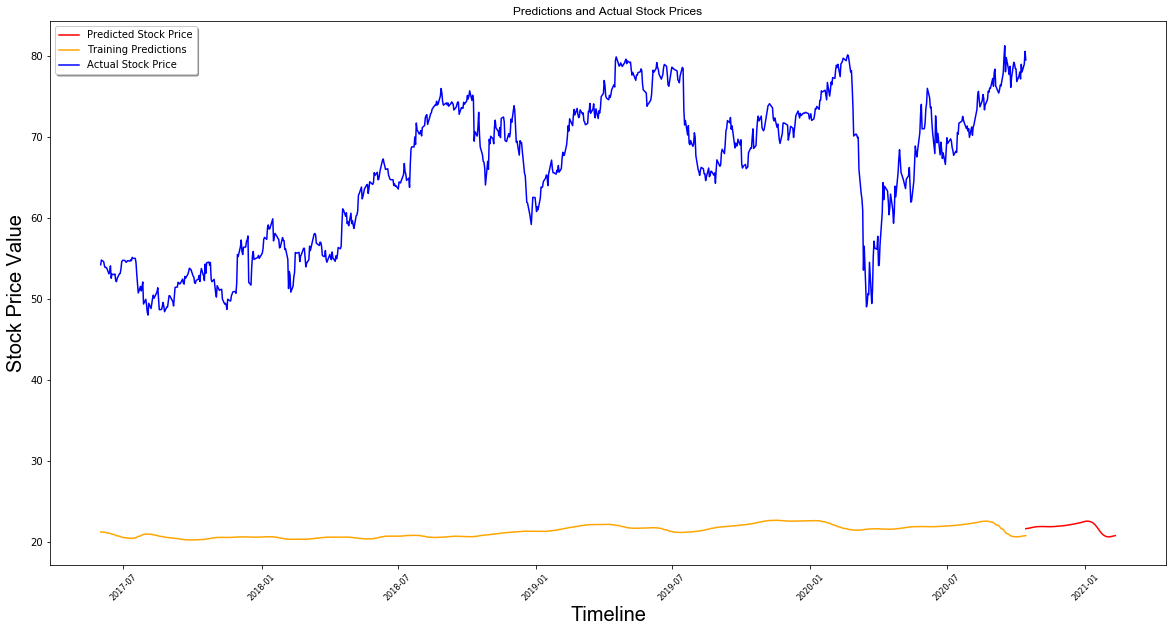

In [19]:
# Plot Parameters

START_DATE_FOR_PLOTTING = '2017-06-01'

plt.plot(PREDICTIONS_FUTURE.index, PREDICTIONS_FUTURE['Open'], color='red', label='Predicted Stock Price')
plt.plot(PREDICTIONS_TRAIN.loc[START_DATE_FOR_PLOTTING:].index, PREDICTIONS_TRAIN.loc[START_DATE_FOR_PLOTTING:]['Open'], color='orange', label='Training Predictions')
plt.plot(dataset_train.loc[START_DATE_FOR_PLOTTING:].index, dataset_train.loc[START_DATE_FOR_PLOTTING:]['Open'], color='blue', label='Actual Stock Price')


plt.legend(shadow=True)
plt.title('Predictions and Actual Stock Prices', family='Arial', fontsize=12)
plt.xlabel('Timeline', family='Arial', fontsize=20)
plt.ylabel('Stock Price Value', family='Arial', fontsize=20)
plt.xticks(rotation=45, fontsize=8)
plt.show()